In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1.9000     ✔ purrr   0.2.4     
✔ tibble  1.4.2          ✔ dplyr   0.7.4     
✔ tidyr   0.8.0          ✔ stringr 1.2.0     
✔ readr   1.2.0          ✔ forcats 0.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


[1] "creditcard-fruad-detection" "creditcardfraud"

According to creditcards.com, there was over £300m in fraudulent credit card transactions in the UK in the first half of 2016, with banks preventing over £470m of fraud in the same period. The data shows that credit card fraud is rising, so there is an urgent need to continue to develop new, and improve current, fraud detection methods.

Using this dataset, we will use machine learning to develop a model that attempts to predict whether or not a transaction is fraudlent. To preserve anonymity, these data have been transformed using principal components analysis.

In [2]:
# load packages
library(readr)
library(dplyr)
library(randomForest)
library(ggplot2)
library(Hmisc)
library(party)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:dplyr’:

    src, summarize

The following objects are masked from ‘package:base’:

    format.pval, units

Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich

Attaching package: ‘strucchange’

The following object is masked from ‘package:stringr’:

    boundary



In [3]:
# set random seed for model reproducibility
set.seed(1234)

In [4]:
# import data
creditData <- read_csv("../input/creditcardfraud/creditcard.csv")

Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


In [5]:
# look at the data
glimpse(creditData)

Observations: 284,807
Variables: 31
$ Time   <dbl> 0, 0, 1, 1, 2, 2, 4, 7, 7, 9, 10, 10, 10, 11, 12, 12, 12, 13...
$ V1     <dbl> -1.3598071, 1.1918571, -1.3583541, -0.9662717, -1.1582331, -...
$ V2     <dbl> -0.07278117, 0.26615071, -1.34016307, -0.18522601, 0.8777367...
$ V3     <dbl> 2.53634674, 0.16648011, 1.77320934, 1.79299334, 1.54871785, ...
$ V4     <dbl> 1.37815522, 0.44815408, 0.37977959, -0.86329128, 0.40303393,...
$ V5     <dbl> -0.33832077, 0.06001765, -0.50319813, -0.01030888, -0.407193...
$ V6     <dbl> 0.46238778, -0.08236081, 1.80049938, 1.24720317, 0.09592146,...
$ V7     <dbl> 0.239598554, -0.078802983, 0.791460956, 0.237608940, 0.59294...
$ V8     <dbl> 0.098697901, 0.085101655, 0.247675787, 0.377435875, -0.27053...
$ V9     <dbl> 0.3637870, -0.2554251, -1.5146543, -1.3870241, 0.8177393, -0...
$ V10    <dbl> 0.09079417, -0.16697441, 0.20764287, -0.05495192, 0.75307443...
$ V11    <dbl> -0.55159953, 1.61272666, 0.62450146, -0.22648726, -0.8228428...
$ V12    <dbl> -

In [6]:
head(creditData)

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.3598071,-0.07278117,2.5363467,1.3781552,-0.33832077,0.46238778,0.23959855,0.09869790,0.3637870,⋯,-0.018306778,0.277837576,-0.11047391,0.06692807,0.1285394,-0.1891148,0.133558377,-0.02105305,149.62,0
0,1.1918571,0.26615071,0.1664801,0.4481541,0.06001765,-0.08236081,-0.07880298,0.08510165,-0.2554251,⋯,-0.225775248,-0.638671953,0.10128802,-0.33984648,0.1671704,0.1258945,-0.008983099,0.01472417,2.69,0
1,-1.3583541,-1.34016307,1.7732093,0.3797796,-0.50319813,1.80049938,0.79146096,0.24767579,-1.5146543,⋯,0.247998153,0.771679402,0.90941226,-0.68928096,-0.3276418,-0.1390966,-0.055352794,-0.05975184,378.66,0
1,-0.9662717,-0.18522601,1.7929933,-0.8632913,-0.01030888,1.24720317,0.23760894,0.37743587,-1.3870241,⋯,-0.108300452,0.005273597,-0.19032052,-1.17557533,0.6473760,-0.2219288,0.062722849,0.06145763,123.50,0
2,-1.1582331,0.87773675,1.5487178,0.4030339,-0.40719338,0.09592146,0.59294075,-0.27053268,0.8177393,⋯,-0.009430697,0.798278495,-0.13745808,0.14126698,-0.2060096,0.5022922,0.219422230,0.21515315,69.99,0
2,-0.4259659,0.96052304,1.1411093,-0.1682521,0.42098688,-0.02972755,0.47620095,0.26031433,-0.5686714,⋯,-0.208253515,-0.559824796,-0.02639767,-0.37142658,-0.2327938,0.1059148,0.253844225,0.08108026,3.67,0


In [7]:
# make Class a factor
creditData$Class <- factor(creditData$Class)

Testing and Training

In [8]:
train <- creditData[1:150000, ]
test <- creditData[150001:284807, ]

In [9]:
train %>%
  select(Class) %>%
  group_by(Class) %>%
  summarise(count = n()) %>%
  glimpse

Observations: 2
Variables: 2
$ Class <fct> 0, 1
$ count <int> 149707, 293


In [10]:
test %>%
  select(Class) %>%
  group_by(Class) %>%
  summarise(count = n()) %>%
  glimpse

Observations: 2
Variables: 2
$ Class <fct> 0, 1
$ count <int> 134608, 199


As we can see, fraudulent transactions are a very small proportion of our dataset, we could build what would appear to be a highly accurate model just by always saying that every transaction was not fraudulent. While we would be right over 99% of the time, that would cost consumers and the industry over £500m per year, so wouldn't be a useful model.

In [11]:
# build random forest model using every variable
rfModel <- randomForest(Class ~ . , data = train)

In [12]:
test$predicted <- predict(rfModel, test)

So we've built a random forest model using all the available variables and used it to predict whether or not a transaction is fraudulent on our test test. As the data is very imbalanced, we would expect our accuracy to be very high, even if our model just always guessed 'not fraudulent'.

In [13]:
library(caret)
confusionMatrix(test$Class, test$predicted)


Attaching package: ‘caret’

The following object is masked from ‘package:survival’:

    cluster

The following object is masked from ‘package:purrr’:

    lift



Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 134573     35
         1     47    152
                                          
               Accuracy : 0.9994          
                 95% CI : (0.9992, 0.9995)
    No Information Rate : 0.9986          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.7873          
 Mcnemar's Test P-Value : 0.2245          
                                          
            Sensitivity : 0.9997          
            Specificity : 0.8128          
         Pos Pred Value : 0.9997          
         Neg Pred Value : 0.7638          
             Prevalence : 0.9986          
         Detection Rate : 0.9983          
   Detection Prevalence : 0.9985          
      Balanced Accuracy : 0.9062          
                                          
       'Positive' Class : 0               
                                          

Looking at the output above, we can indeed see that we have very high accuracy (99.94%) as we expected. Going back to our test set class counts, we can see that we had 134,608 legitimate transactions, and 199 fraudulent transactions. Had we said that every transaction was fraudulent, we would have got 199 wrong.

In [14]:
library(MLmetrics)


Attaching package: ‘MLmetrics’

The following objects are masked from ‘package:caret’:

    MAE, RMSE

The following object is masked from ‘package:base’:

    Recall



In [15]:
F1_all <- F1_Score(test$Class, test$predicted)
F1_all

[1] 0.9996954

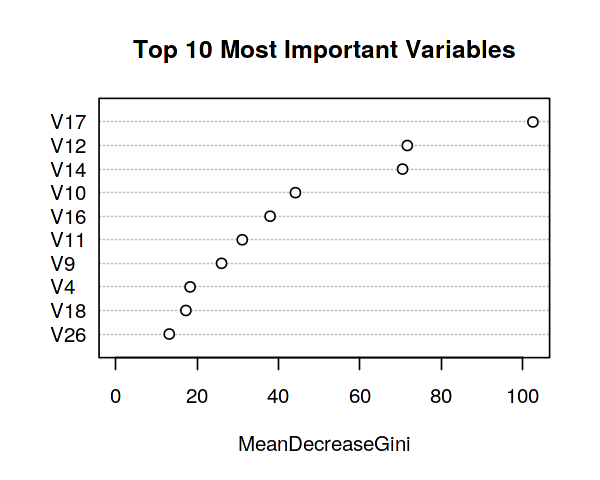

In [16]:
options(repr.plot.width=5, repr.plot.height=4)
varImpPlot(rfModel,
          sort = T,
           n.var=10,
           main="Top 10 Most Important Variables")

In [17]:
rfModelTrim1 <- randomForest(Class ~  V17, 
                            data = train)

test$predictedTrim1 <- predict(rfModelTrim1, test)

F1_1 <- F1_Score(test$Class, test$predictedTrim1)
F1_1

[1] 0.9993278

In [18]:
rfModelTrim2 <- randomForest(Class ~  V17 + V12, 
                            data = train)

test$predictedTrim2 <- predict(rfModelTrim2, test)

F1_2 <- F1_Score(test$Class, test$predictedTrim2)
F1_2

[1] 0.9996064

In [19]:
rfModelTrim3 <- randomForest(Class ~  V17 + V12 + V14, 
                            data = train)

test$predictedTrim3 <- predict(rfModelTrim3, test)

F1_3 <- F1_Score(test$Class, test$predictedTrim3)
F1_3

[1] 0.9995691

In [20]:
# four variables
rfModelTrim4 <- randomForest(Class ~  V17 + V12 + V14 + V10, 
                            data = train)

test$predictedTrim4 <- predict(rfModelTrim4, test)

F1_4 <- F1_Score(test$Class, test$predictedTrim4)
F1_4

[1] 0.9996286

In [21]:
# five variables
rfModelTrim5 <- randomForest(Class ~  V17 + V12 + V14 + V10 + V16, 
                            data = train)

test$predictedTrim5 <- predict(rfModelTrim5, test)

F1_5 <- F1_Score(test$Class, test$predictedTrim5)
F1_5

[1] 0.9996434

In [22]:
# ten variables
rfModelTrim10 <- randomForest(Class ~  V17 + V12 + V14 + V10 + V16 
                              + V11 + V9 + V4 + V18 + V26, 
                            data = train)

test$predictedTrim10 <- predict(rfModelTrim10, test)

F1_10 <- F1_Score(test$Class, test$predictedTrim10)
F1_10

[1] 0.9997177

With those scores calculated, let's go ahead and plot those out:

In [23]:
# build dataframe of number of variables and scores
numVariables <- c(1,2,3,4,5,10,17)
F1_Score <- c(F1_1, F1_2, F1_3, F1_4, F1_5, F1_10, F1_all)
variablePerf <- data.frame(numVariables, F1_Score)

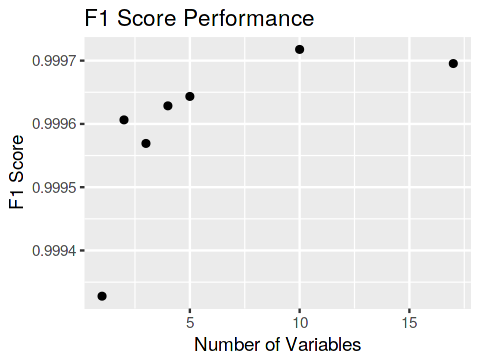

In [24]:
# plot score performance against number of variables
options(repr.plot.width=4, repr.plot.height=3)
ggplot(variablePerf, aes(numVariables, F1_Score)) + geom_point() + labs(x = "Number of Variables", y = "F1 Score", title = "F1 Score Performance")

In [25]:
rf10 = randomForest(Class ~  V17 + V12 + V14 + V10 + V16 
                              + V11 + V9 + V4 + V18 + V26,  
                   ntree = 1000,
                   data = train)

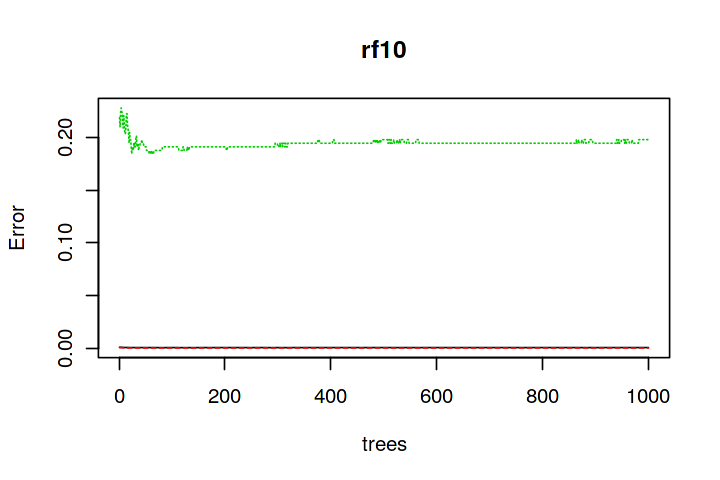

In [26]:
options(repr.plot.width=6, repr.plot.height=4)
plot(rf10)

Plotting our 10-variable model shows that there is not much additional performance gained after what looks like about 50 trees, but let's zoom in on that region to make sure:

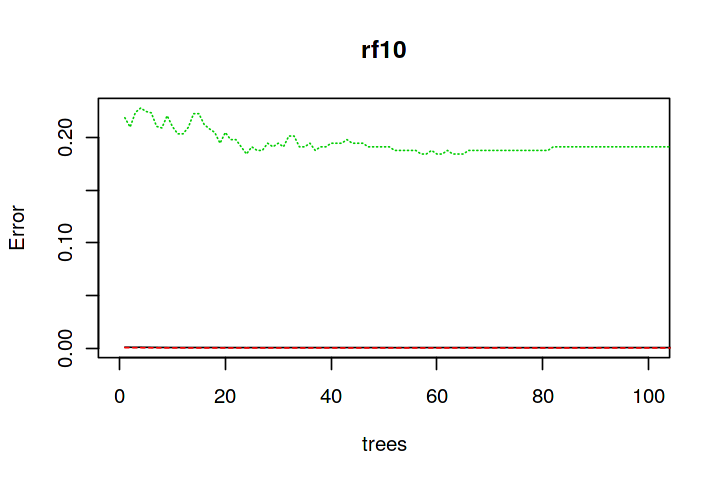

In [27]:
options(repr.plot.width=6, repr.plot.height=4)
plot(rf10, xlim=c(0,100))

## Summing up
We have used a random forest method to predict whether or not a credit card transaction is fraudulent or not, and built a model that offers a useful uplift over the no information rate.

This basic model provides a starting point for contintinuing to tune the model to seek additional improvements. Although we are dealing with changes in accuracy at the fourth decimal place, these very slight changes in accuracy need to be considered with respect to the volume of credit card transactions that take place every year. Even with only a slight fraction of these being fraudulent, the sheer volume of transactions mean that even very slight improvements in model performance may result in significant reductions in credit card fraud.